In [250]:
import numpy as np
from scipy.special import gamma
from sympy import symbols, diff, lambdify
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from typing import Callable, Tuple

In [251]:
x , y = symbols('x y')
f = 4*x**2 - 4*x*y + 2*y**2
# f = (x**6+y**4-17)**2 + (2*x+y-4)**2

Min = np.array([0,0])
# Min = np.array([1,2])

xm1 = np.array([0.1, 0.5])
x0 = np.array([1.5, 2.5])
Xs = [xm1, x0]

tol = 1e-9

beta = 0.1
alpha_f = lambda x: 1 - 2 / np.pi * np.arctan(beta * x)

In [252]:
def gradient(f) -> Callable[[np.ndarray], np.ndarray]:
    grad_f = [diff(f, var) for var in (x, y)]
    grad_f_lambdified = lambdify((x, y), grad_f)
    return lambda Xk: np.array(grad_f_lambdified(*Xk), dtype=float)

def fractional_grad(f) -> Callable[[np.ndarray, np.ndarray, float], np.ndarray]:
    grad_f = [diff(f, var) for var in (x, y)]
    grad_f_lambdified = lambdify((x, y), grad_f)
    return lambda Xk, Xkm1, alpha: np.array(grad_f_lambdified(*Xkm1), dtype=float) * (abs(Xk - Xkm1)**(1 - alpha)) / gamma(2 - alpha)

In [253]:
J_ = gradient(f)(xm1)
aal = alpha_f(np.linalg.norm(J_))
aal

0.8743340836219976

In [254]:
fractional_grad(f)(x0, xm1, aal)

array([-1.32961075,  1.85408291])

In [255]:
def descent(f,Xs:list,alpha_f,tol,verbose=False):
    grad_f = gradient(f)
    grad_f_frac = fractional_grad(f)
    ff = lambdify((x, y), f)
    
    limit_iter = 5000
    for i in range(1,limit_iter):
        Xk = Xs[i]
        Xkm1 = Xs[i-1]
        J = np.linalg.norm(grad_f(Xkm1))
        alpha = alpha_f(J)
        
        grad_frac = grad_f_frac(Xk, Xkm1, alpha)
        if np.linalg.norm(grad_frac) < tol:
            print(f"Converged at iteration {i}: Xk = {Xk}, J = {J}, alpha = {alpha}")
            break
        
        h = minimize_scalar(
            lambda h: ff(*(Xk - h * grad_frac)),
            bounds=(0, 2), method='bounded',
        ).x
        
        Xkp1 = Xk - h * grad_frac
        Xs.append(Xkp1)
        
        if verbose:
            print(f"Iteration {i}: Xk = {Xk}, J = {J}, alpha = {alpha}, h = {h}, grad_frac = {grad_frac}")
        
    return Xs[-1] , grad_frac , alpha, h , i
        

In [256]:
Xk , fractional_gradient , alpha1_val , optimal_h , i = descent(f,Xs,alpha_f,tol,verbose=True)

Iteration 1: Xk = [1.5 2.5], J = 2.0, alpha = 0.8743340836219976, h = 0.09990763686083903, grad_frac = [-1.32961075  1.85408291]
Iteration 2: Xk = [1.63283827 2.31476296], J = 4.47213595499958, alpha = 0.7322795271987699, h = 0.786205232003156, grad_frac = [1.29025019 2.82074616]
Iteration 3: Xk = [0.61843681 0.09707757], J = 4.680611780716712, alpha = 0.7213058954855005, h = 0.15736894638100257, grad_frac = [4.23870539 3.78005587]
Iteration 4: Xk = [-0.04860379 -0.49778584], J = 5.013502599052107, alpha = 0.7041454544625063, h = 0.043201958105582056, grad_frac = [ 4.5033186  -1.99126138]
Iteration 5: Xk = [-0.24315597 -0.41175945], J = 2.407413434796578, alpha = 0.8496012332034419, h = 0.013894517031179165, grad_frac = [ 1.34270282 -1.33172002]
Iteration 6: Xk = [-0.26181218 -0.39325584], J = 0.7374030881417569, alpha = 0.9531402739119478, h = 0.6505816149561772, grad_frac = [-0.25378928 -0.57373392]
Iteration 7: Xk = [-0.09670154 -0.0199951 ], J = 0.7405229022658527, alpha = 0.952942



 Variable alpha and optimize theta (Trained) (Python/NumPy):
X_0: [1.5 2.5]
f(X_0): 6.500000
Minimum successfully obtained...
Number of Iterations for Convergence: 50
alpha_k: [1.000000]
theta_k (approximate optimal h): 0.006672
X_k: [9.34833686e-11 1.42129961e-10]
f(X_k): 0.000000
Error Approximation: 0.000000


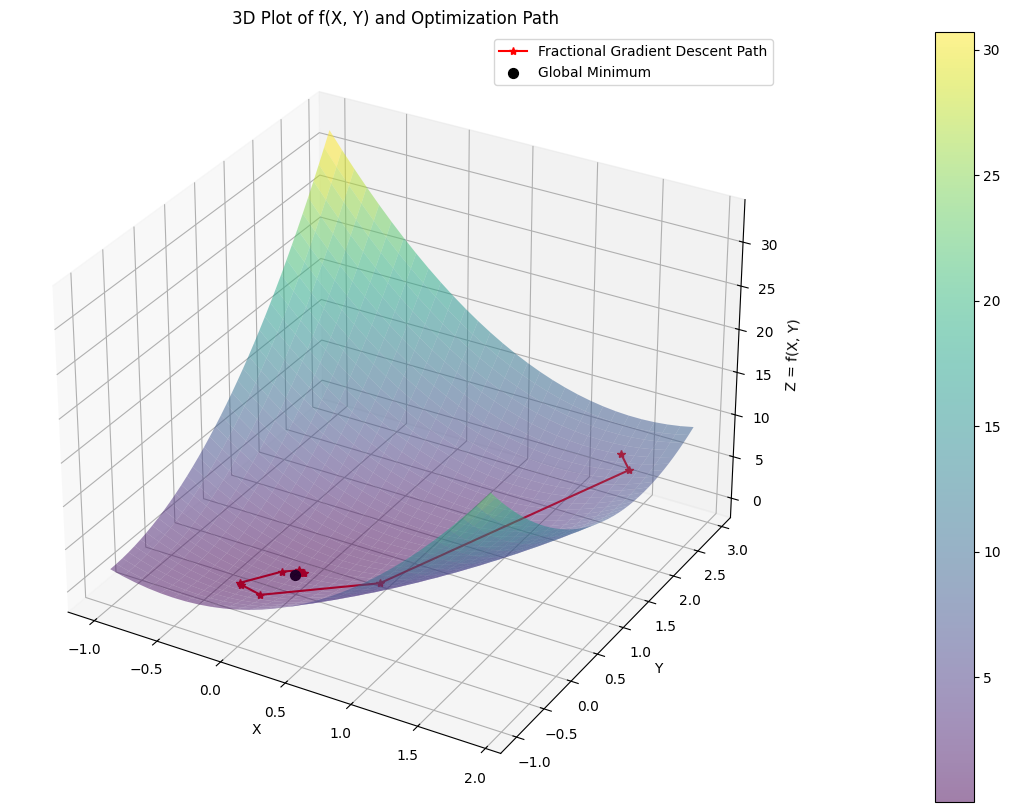

In [257]:
print("\n\n Variable alpha and optimize theta (Trained) (Python/NumPy):")
print(f"X_0: {x0}")
ff = lambdify((x, y), f)
print(f"f(X_0): {ff(*x0):.6f}")
if np.linalg.norm(fractional_gradient) < tol:
    print("Minimum successfully obtained...")
else:
    print("Maximum iterations reached or convergence not achieved.")
print(f"Number of Iterations for Convergence: {i}")
print(f"alpha_k: [{alpha1_val:.6f}]")
print(f"theta_k (approximate optimal h): {optimal_h:.6f}")
print(f"X_k: {Xk}")
print(f"f(X_k): {ff(*Xk):.6f}")
print(f"Error Approximation: {np.linalg.norm(Xk - Min):.6f}")
# Generate level curves for visualization
ff = lambdify((x, y), f, 'numpy')

# Generate data for the 3D plot
delta = 0.1
x_range = np.arange(-1, 2, delta)
y_range = np.arange(-1, 3, delta)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = ff(X_grid, Y_grid)

# Create the 3D plot
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the surface
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.5) # Added alpha
fig.colorbar(surf)  # Add a color bar to the plot
if 'Xs' in locals():
    x_vals = [point[0] for point in Xs[1:]]
    y_vals = [point[1] for point in Xs[1:]]
    z_vals = [ff(point[0], point[1]) for point in Xs[1:]] # Calculate z values
    ax.plot(x_vals, y_vals, z_vals, '*-r', label='Fractional Gradient Descent Path') # plot the path
    ax.scatter(Min[0], Min[1], ff(*Min), color='black', marker='o', s=50, label='Global Minimum') # plot the minimum
else:
    print("Warning: 'Xs' is not defined.  Cannot plot the optimization path.")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z = f(X, Y)')
ax.set_title('3D Plot of f(X, Y) and Optimization Path')
ax.legend()

plt.show()
